In [67]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.sparse as sp
import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split as sp_train_test_split
from scipy.sparse import csr_matrix


In [29]:
# read files
ratings = pd.read_csv('rating.csv') 
movies = pd.read_csv('movie.csv')  
tags = pd.read_csv('tag.csv')  

# merge `rating.csv` and `movie.csv`, using movieId 
rating_movie_merged = pd.merge(ratings, movies, on='movieId')
rating_movie_merged.head()

# merge rating_movie and tags
final_merged_data = pd.merge(rating_movie_merged, tags, on=['movieId', 'userId'], how='inner')

# check final dataframe
final_merged_data.head()

,userId,movieId,rating,timestamp_x,title,genres,tag,timestamp_y
0,65,27866,4.0,2011-05-09 16:05:59,In My Father's Den (2004),Drama,New Zealand,2011-05-09 16:05:53
1,65,48082,4.5,2011-05-09 16:26:19,"Science of Sleep, The (La science des rêves) (...",Comedy|Drama|Fantasy|Romance,surreal,2011-05-09 16:25:54
2,65,48082,4.5,2011-05-09 16:26:19,"Science of Sleep, The (La science des rêves) (...",Comedy|Drama|Fantasy|Romance,unusual,2011-05-09 16:25:59
3,65,58652,5.0,2011-05-09 16:09:31,CJ7 (Cheung Gong 7 hou) (2008),Children|Comedy|Sci-Fi,cute,2011-05-09 16:13:32
4,65,58652,5.0,2011-05-09 16:09:31,CJ7 (Cheung Gong 7 hou) (2008),Children|Comedy|Sci-Fi,emotional,2011-05-09 16:13:28


In [30]:
# delete extra timestamp
final_merged_data = final_merged_data.drop('timestamp_y', axis=1)
final_merged_data['timestamp'] = final_merged_data['timestamp_x']
final_merged_data = final_merged_data.drop('timestamp_x', axis=1)
final_merged_data.head()

,userId,movieId,rating,title,genres,tag,timestamp
0,65,27866,4.0,In My Father's Den (2004),Drama,New Zealand,2011-05-09 16:05:59
1,65,48082,4.5,"Science of Sleep, The (La science des rêves) (...",Comedy|Drama|Fantasy|Romance,surreal,2011-05-09 16:26:19
2,65,48082,4.5,"Science of Sleep, The (La science des rêves) (...",Comedy|Drama|Fantasy|Romance,unusual,2011-05-09 16:26:19
3,65,58652,5.0,CJ7 (Cheung Gong 7 hou) (2008),Children|Comedy|Sci-Fi,cute,2011-05-09 16:09:31
4,65,58652,5.0,CJ7 (Cheung Gong 7 hou) (2008),Children|Comedy|Sci-Fi,emotional,2011-05-09 16:09:31


In [31]:
# check null value
final_merged_data.isnull().sum()

userId       0
movieId      0
rating       0
title        0
genres       0
tag          1
timestamp    0
dtype: int64

In [32]:
# mark NaN as 'unknown'
final_merged_data['tag'] = final_merged_data['tag'].fillna('unknown')
final_merged_data.isnull().sum() 

userId       0
movieId      0
rating       0
title        0
genres       0
tag          0
timestamp    0
dtype: int64

In [33]:
final_merged_data.describe()

,userId,movieId,rating
count,391445.000000,391445.000000,391445.000000
mean,67291.897587,32766.306189,3.780652
std,42227.513945,35997.920748,1.024136
min,65.000000,1.000000,0.500000
25%,27898.000000,2502.000000,3.000000
50%,66635.000000,7361.000000,4.000000
75%,106755.000000,63072.000000,4.500000
max,138472.000000,131258.000000,5.000000


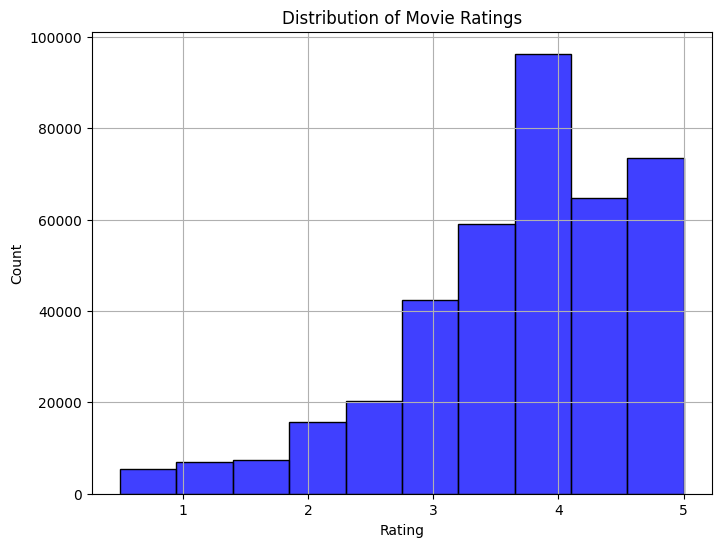

In [34]:
# visualize rating distribution
plt.figure(figsize=(8, 6))
sns.histplot(final_merged_data['rating'], bins=10, kde=False, color='blue', kde_kws={'bw_adjust': 2})
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(True)
plt.show()

This is a positively skewed distribution, i.e. most of the ratings for movies tend to be high. Many users tend to give high ratings (close to 5) to the movies they like, and fewer users give very low ratings (such as 1).

In [35]:
# split genres col, make each genre a list
final_merged_data['genres_split'] = final_merged_data['genres'].str.split('|')

# use explode to show genre as independent row and save the result as a new dataframe
genres_exploded = final_merged_data.explode('genres_split')

# count each genre's appearance
genre_counts = genres_exploded['genres_split'].value_counts()
genre_counts

genres_split
Drama                 200635
Comedy                118912
Thriller              115062
Action                107325
Sci-Fi                 78375
Adventure              77199
Romance                68338
Crime                  68294
Fantasy                46217
Mystery                42494
Horror                 36259
IMAX                   24988
Animation              23644
Children               20552
War                    19584
Musical                13097
Documentary             9032
Film-Noir               5888
Western                 5607
(no genres listed)        46
Name: count, dtype: int64

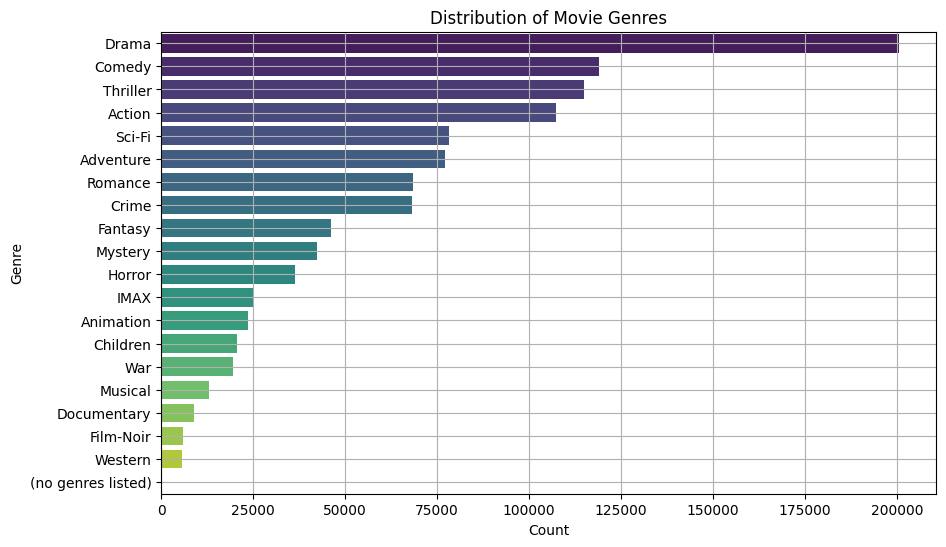

In [36]:
# visualize genre distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Distribution of Movie Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.grid(True)
plt.show()

Most popular movie genre is Drama. Comedy, Thriller, Action is also popular. Film-Noir, Western and  Musical have less audience.

In [37]:
# convert timestamp to datetime format
final_merged_data['timestamp'] = pd.to_datetime(final_merged_data['timestamp'])

# extract year and month
final_merged_data['year'] = final_merged_data['timestamp'].dt.year
final_merged_data['month'] = final_merged_data['timestamp'].dt.month

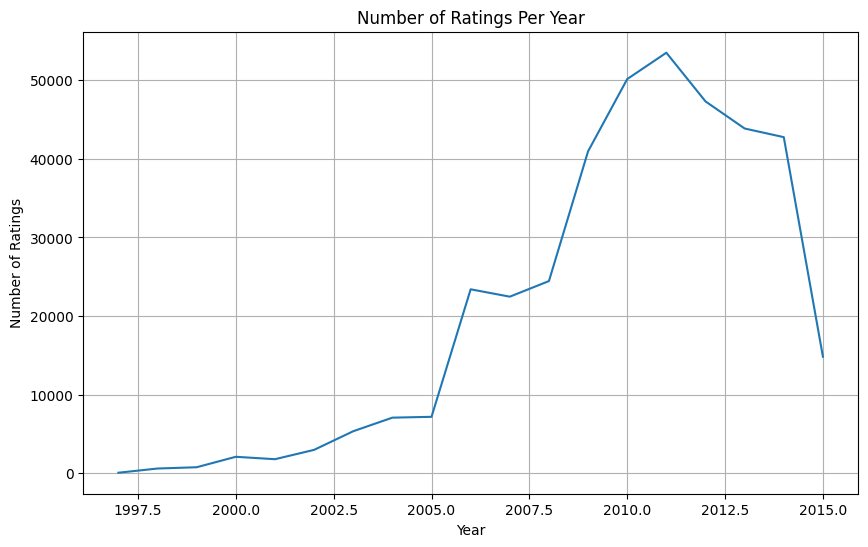

In [38]:
# calculate ratings based on year
ratings_per_year = final_merged_data.groupby('year').size()

# visualize
plt.figure(figsize=(10, 6))
plt.plot(ratings_per_year.index, ratings_per_year.values)
plt.title('Number of Ratings Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.grid(True)
plt.show()

There is a sharp increase in the number of ratings between 2005 and 2010, followed by a significant drop after 2011. Such fluctuations may be related to specific events or trends in the dataset, or to changes in the movie recommendation system and user behavior.

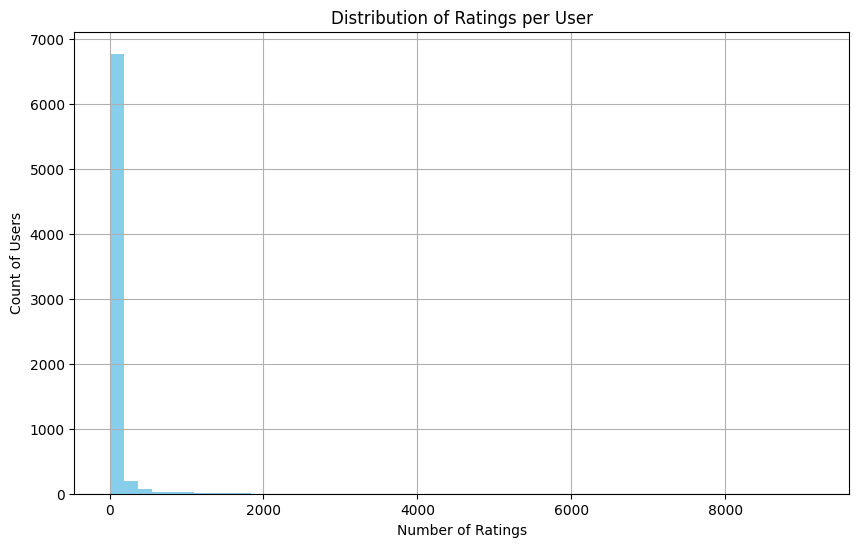

In [39]:
# count the number of ratings for each user 
user_rating_counts = final_merged_data.groupby('userId').size()

# visualize Distribution of Ratings per User
plt.figure(figsize=(10, 6))
plt.hist(user_rating_counts, bins=50, color='skyblue')
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.grid(True)
plt.show()

This is a typical long-tail distribution, where most users have a low number of ratings (less than 100), while a few active users have a large number of ratings.

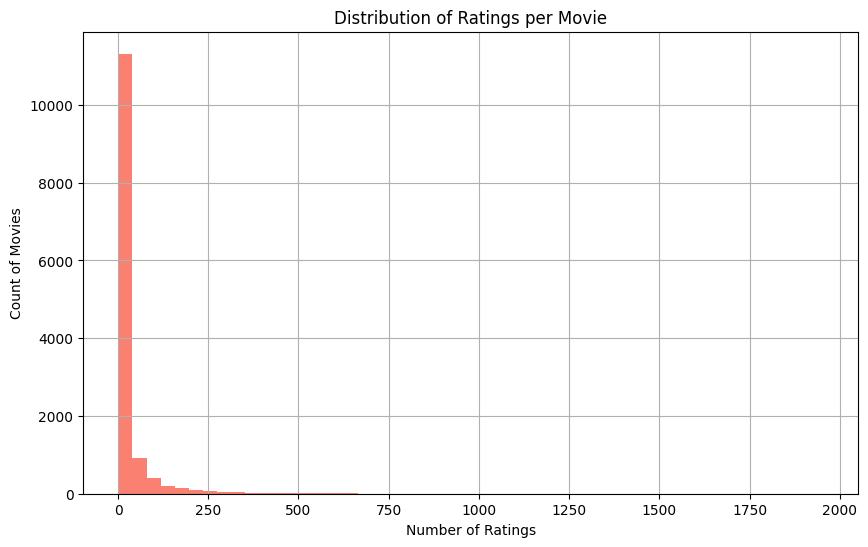

In [40]:
# Count the number of ratings for each movie
movie_rating_counts = final_merged_data.groupby('movieId').size()

# visualize 'Distribution of Ratings per Movie
plt.figure(figsize=(10, 6))
plt.hist(movie_rating_counts, bins=50, color='salmon')
plt.title('Distribution of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Movies')
plt.grid(True)
plt.show()

This is also a typical long-tail distribution, where most movies have very few ratings, while a few movies have a very large number of ratings.

In [41]:
# Computing the sparsity of the rating matrix
total_possible_ratings = final_merged_data['userId'].nunique() * final_merged_data['movieId'].nunique()
actual_ratings = len(final_merged_data)
sparsity = 1 - (actual_ratings / total_possible_ratings)
print(f"Sparsity of the rating matrix: {sparsity:.4f}")

Sparsity of the rating matrix: 0.9959


The sparsity of the rating matrix is 0.9959, which means that 99.59% of user-movie pairs have no ratings, and only 0.41% of user-movie pairs have rating data. This shows that the dataset is very sparse, with relatively few ratings, and most users have not rated most movies.

In [42]:
# Filter out users who have rated less than 20 times
active_users = user_rating_counts[user_rating_counts >= 20].index
final_merged_data = final_merged_data[final_merged_data['userId'].isin(active_users)]

# Filter out movies with less than 50 ratings
popular_movies = movie_rating_counts[movie_rating_counts >= 50].index
final_merged_data = final_merged_data[final_merged_data['movieId'].isin(popular_movies)]

In [43]:
# Computing the sparsity of the rating matrix again
total_possible_ratings = final_merged_data['userId'].nunique() * final_merged_data['movieId'].nunique()
actual_ratings = len(final_merged_data)
sparsity = 1 - (actual_ratings / total_possible_ratings)
print(f"Sparsity of the rating matrix: {sparsity:.4f}")

Sparsity of the rating matrix: 0.9166


Sparsity got improved.

In [44]:
# LabelEncoder for userId 
user_encoder = LabelEncoder()
final_merged_data['userId_encoded'] = user_encoder.fit_transform(final_merged_data['userId'])

# LabelEncoder for movieId:
movie_encoder = LabelEncoder()
final_merged_data['movieId_encoded'] = movie_encoder.fit_transform(final_merged_data['movieId'])

# check data after labelencoding
final_merged_data[['userId', 'userId_encoded', 'movieId', 'movieId_encoded']].head()

,userId,userId_encoded,movieId,movieId_encoded
23,121,0,778,121
24,121,0,778,121
25,121,0,778,121
26,121,0,778,121
27,121,0,1288,274


In [68]:
# Load rating data and build a rating matrix
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(final_merged_data[['userId_encoded', 'movieId_encoded', 'rating']], reader)

# train test split
trainset, testset = sp_train_test_split(data, test_size=0.2)

# initiate a SVD object
svd = SVD()

# train on SVD 
svd.fit(trainset)

# predict
predictions = svd.test(testset)
accuracy.rmse(predictions) 

RMSE: nan


nan

The RMSE result show that the prediction error of the model is within a reasonable range, indicating that the performance of the model is good.

In [46]:
# generate movie recommendations for specific user
# take an example at userid is 121
user_id = 121

# obtain user rated movies
user_rated_movies = final_merged_data[final_merged_data['userId_encoded'] == user_id]['movieId_encoded'].values
all_movies = final_merged_data['movieId_encoded'].unique()

# obtain user unrated movies
unrated_movies = [movie for movie in all_movies if movie not in user_rated_movies]

# we are going to recommend some unrated movies fot this user based on his rated movies
for movie_id in unrated_movies[:5]:  
    prediction = svd.predict(user_id, movie_id)
    movie_title = final_merged_data[final_merged_data['movieId_encoded'] == movie_id]['title'].values[0]
    print(f"predict movie '{movie_title}'s rating: {prediction.est}")

predict movie 'Trainspotting (1996)'s rating: 4.807708900549871
predict movie 'This Is Spinal Tap (1984)'s rating: 4.506922170906443
predict movie 'American Pie (1999)'s rating: 3.6983170833017414
predict movie 'American Pie 2 (2001)'s rating: 3.4922087237567463
predict movie 'National Lampoon's Van Wilder (2002)'s rating: 3.6208776561727856


In [47]:
# use MultiLabelBinarizer to One-Hot encode genres

mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(final_merged_data['genres_split'])

# convert the result of One-Hot to DataFrame and add it to the original dataset
genres_encoded_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)
final_merged_data = pd.concat([final_merged_data, genres_encoded_df], axis=1)

# delete the original genres column and genres_split coloumn
final_merged_data.drop(['genres', 'genres_split'], axis=1, inplace=True)
final_merged_data.head()

,userId,movieId,rating,title,tag,timestamp,year,month,userId_encoded,movieId_encoded,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
23,121.0,778.0,4.0,Trainspotting (1996),dark comedy,2011-03-23 04:00:30,2011.0,3.0,0.0,121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,121.0,778.0,4.0,Trainspotting (1996),drugs,2011-03-23 04:00:30,2011.0,3.0,0.0,121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,121.0,778.0,4.0,Trainspotting (1996),Nudity (Full Frontal - Notable),2011-03-23 04:00:30,2011.0,3.0,0.0,121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,121.0,778.0,4.0,Trainspotting (1996),Nudity (Full Frontal),2011-03-23 04:00:30,2011.0,3.0,0.0,121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,121.0,1288.0,4.5,This Is Spinal Tap (1984),Christopher Guest,2011-04-01 06:48:07,2011.0,4.0,0.0,274.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
# generate movie recommendations based on similar content
#!!!!!!!!!!!!!!!!!!!!!!!!!!still need to modify!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Assume that the user has watched the movie index list
user_rated_movie_indices = [0, 5, 20]  # Assume the user has watched these movies

# Calculate the similarity of only these movies to all other movies
for idx in user_rated_movie_indices:
    sim_movies = cosine_similarity(content_features.iloc[idx].values.reshape(1, -1), content_features.values)
    
    # Sort and get the top 5 movies with the highest similarity (excluding itself)
    similar_movies_indices = sim_movies.argsort()[0][-6:-1]  # Get the indexes of the top 5 similar movies, excluding itself
    similar_movies_scores = sim_movies[0][similar_movies_indices]
    
    # De-duplicate movie titles
    seen_movie_titles = set()  # Store the recommended movie titles
    print(f"Similar movie recommendations for users who have watched movie {idx}:")
    
    for movie_idx, score in zip(similar_movies_indices, similar_movies_scores):
        movie_title = final_merged_data.iloc[movie_idx]['title']
        
        if movie_title not in seen_movie_titles:  # De-duplicate based on title
            print(f"movie: {movie_title}, similarity: {score}")
            seen_movie_titles.add(movie_title)  # Add movie title to the set to avoid duplication

Similar movie recommendations for users who have watched movie 0:
movie: Johnny Mnemonic (1995), similarity: 1.0
movie: Office Space (1999), similarity: 1.0
movie: Easy Rider (1969), similarity: 1.0
Similar movie recommendations for users who have watched movie 5:
movie: Johnny Mnemonic (1995), similarity: 1.0
movie: Office Space (1999), similarity: 1.0
movie: Easy Rider (1969), similarity: 1.0
Similar movie recommendations for users who have watched movie 20:
movie: Adaptation (2002), similarity: 1.0
movie: Ghost World (2001), similarity: 1.0
movie: Evil Dead, The (1981), similarity: 1.0
movie: Up (2009), similarity: 1.0


In [49]:
# define stopwords
stop_words = set(stopwords.words('english'))

# preprocess the text
def preprocess_tags(text):
    text = text.lower() # convert text to lower
    text = re.sub(r'[^\w\s]', '', text) # remove punctuation
    text = ' '.join([word for word in text.split() if word not in stop_words]) # remove stopwords
    return text

# preprocess tag column
final_merged_data['tags_processed'] = final_merged_data['tag'].fillna('').apply(preprocess_tags)

# use TF-IDF to vectorize `tags` colomn 
tfidf = TfidfVectorizer(max_features=1000)
tags_tfidf_matrix = tfidf.fit_transform(final_merged_data['tags_processed'])

In [50]:
# Check the data type of each column
final_merged_data.dtypes

userId                    float64
movieId                   float64
rating                    float64
title                      object
tag                        object
timestamp          datetime64[ns]
year                      float64
month                     float64
userId_encoded            float64
movieId_encoded           float64
Action                    float64
Adventure                 float64
Animation                 float64
Children                  float64
Comedy                    float64
Crime                     float64
Documentary               float64
Drama                     float64
Fantasy                   float64
Film-Noir                 float64
Horror                    float64
IMAX                      float64
Musical                   float64
Mystery                   float64
Romance                   float64
Sci-Fi                    float64
Thriller                  float64
War                       float64
Western                   float64
tags_processed

In [51]:
# define target first to prevent data leakage
y = final_merged_data['rating'].values

# Delete non-numeric columns (such as 'title', 'tag', 'timestamp', 'tags_processed') and target
final_merged_data_numeric = final_merged_data.drop(columns=['title', 'tag', 'timestamp', 'tags_processed', 'rating'])

# Convert the processed numerical features into a sparse matrix
final_merged_data_sparse = sp.csr_matrix(final_merged_data_numeric.values)

# Merge the numerical sparse matrix and the TF-IDF sparse matrix
final_merged_data_combined = sp.hstack([final_merged_data_sparse, tags_tfidf_matrix])

In [69]:
# define features 
X = final_merged_data_combined  

# train test split
X_train, X_test, y_train, y_test = sk_train_test_split(X, y, test_size=0.2, random_state=42)

# check shape
print(X_train.shape)
print(X_test.shape)

(280217, 1025)
(70055, 1025)
